## Import Python libraries
---
Start by `pip install -U -r requirements.txt --user `

In [1]:
#! pip install -U -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
import random
from scipy.stats import pearsonr
import datetime
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from dateutil.relativedelta import relativedelta

# Graphics
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 20000)
pd.set_option('display.width', 10000)

# Temp
from meteostat import Stations, Daily
from geopy.geocoders import Nominatim
from itertools import product
geolocator = Nominatim(user_agent='myapplication')

path = '../data/'

In [3]:
# Graphical Parameters from Matplotlib
CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'
color_list = [CB91_Blue, CB91_Pink, CB91_Green, CB91_Amber,
              CB91_Purple, CB91_Violet]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)
plt.rcParams['figure.figsize'] = [40, 15]
plt.rcParams['figure.dpi'] = 75 # 200 e.g. is really fine, but slower
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)

## Data Engineering
---

### Preprocessing

In [6]:
# Read the CSV file, delete unnamed columns, creates load factor, keeps only number of seats > 10, creates DATE column
def read_n_clean(name):
  df = pd.read_csv(name)
  # Drop Unnamed Columns
  df.drop(df.columns[df.columns.str.contains('unnamed', case=False)], axis = 1, inplace = True)
  df['DATE'] =  pd.to_datetime(df[['YEAR', 'MONTH']].assign(DAY=1))
  # We pick only data from 2014 to 2019
  date_ref1 = datetime.datetime(2014, 1, 1)
  date_ref2 = datetime.datetime(2020, 1, 1)
  df = df[(df['DATE'] >= date_ref1) & (df['DATE'] < date_ref2)]
  # We pick only flights with available seats > 10
  df = df[df["SEATS"] > 10].reset_index(drop=True)  
  # We pick only flights with non-null distance travelled 
  df = df[df["DISTANCE"] > 0].reset_index(drop=True) 
  # We dropped the Hageland Airline data -> the company has shut down since 2008 and has very low amounts of tweets
  df = df[df['UNIQUE_CARRIER'] != "H6"]
  # Load-Factor Creation
  df["RPM"] = df["PASSENGERS"] * df["DISTANCE"]
  df["ASM"] = df["SEATS"] * df["DISTANCE"]
  return df

In [9]:
df = read_n_clean(path + "T_100_Domestic_Segment_All_Years_Extended.csv")
df.head()

,DEPARTURES_SCHEDULED,DEPARTURES_PERFORMED,PAYLOAD,SEATS,PASSENGERS,FREIGHT,MAIL,DISTANCE,UNIQUE_CARRIER,AIRLINE_ID,UNIQUE_CARRIER_NAME,CARRIER_NAME,CARRIER_GROUP,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,AIRCRAFT_GROUP,AIRCRAFT_TYPE,AIRCRAFT_CONFIG,YEAR,MONTH,DISTANCE_GROUP,CLASS,DATE,RPM,ASM
0,0.0,1.0,22900.0,88.0,68.0,0.0,0.0,1149.0,CP,21167.0,Compass Airlines,Compass Airlines,2,10423,AUS,"Austin, TX",TX,11433,DTW,"Detroit, MI",MI,6,677,1,2015,3,3,F,2015-03-01,78132.0,101112.0
1,0.0,9.0,206100.0,792.0,430.0,0.0,0.0,1042.0,CP,21167.0,Compass Airlines,Compass Airlines,2,10423,AUS,"Austin, TX",TX,13487,MSP,"Minneapolis, MN",MN,6,677,1,2015,3,3,F,2015-03-01,448060.0,825264.0
2,0.0,1.0,22900.0,88.0,69.0,0.0,0.0,748.0,CP,21167.0,Compass Airlines,Compass Airlines,2,10620,BIL,"Billings, MT",MT,13487,MSP,"Minneapolis, MN",MN,6,677,1,2015,3,2,F,2015-03-01,51612.0,65824.0
3,0.0,1.0,21850.0,86.0,27.0,0.0,0.0,386.0,CP,21167.0,Compass Airlines,Compass Airlines,2,10627,BIS,"Bismarck/Mandan, ND",ND,13487,MSP,"Minneapolis, MN",MN,6,673,1,2015,3,1,F,2015-03-01,10422.0,33196.0
4,0.0,1.0,22900.0,88.0,64.0,0.0,0.0,500.0,CP,21167.0,Compass Airlines,Compass Airlines,2,11057,CLT,"Charlotte, NC",NC,11433,DTW,"Detroit, MI",MI,6,677,1,2015,3,2,F,2015-03-01,32000.0,44000.0


### Airlines Global Performance - Choosing the best relevant airlines

In [10]:

# MOY FLIGHTS
count_flights = df.groupby(['UNIQUE_CARRIER_NAME', 'DATE'])['PASSENGERS'].count().reset_index(name = 'NB_FLIGHTS')
count_flights_f = count_flights.groupby(['UNIQUE_CARRIER_NAME'])['NB_FLIGHTS'].mean().reset_index(name = 'MOY_NB_FLIGHTS').sort_values('MOY_NB_FLIGHTS', ascending = False)


# TOT Passengers
tot_pass = count_flights_f.merge(df.groupby(['UNIQUE_CARRIER_NAME'])['PASSENGERS'].sum().reset_index(name = 'TOT_PASS_FLIGHTS').reset_index(drop=True), on= ['UNIQUE_CARRIER_NAME']).sort_values('TOT_PASS_FLIGHTS', ascending = False)

# NB Flights
tot_nb_flights = tot_pass.merge(df.groupby(['UNIQUE_CARRIER_NAME'])['PASSENGERS'].count().reset_index(name = 'TOT_NB_FLIGHTS').reset_index(drop=True), on=['UNIQUE_CARRIER_NAME']).sort_values('TOT_NB_FLIGHTS', ascending = False)


In [11]:
copy = tot_nb_flights.copy()
scaler = StandardScaler()
copy.iloc[:, 1:] = scaler.fit_transform(copy.iloc[:, 1:])
copy['TOTAL'] = copy['MOY_NB_FLIGHTS'] + copy['TOT_PASS_FLIGHTS'] + copy['TOT_NB_FLIGHTS']
copy.sort_values('TOTAL', ascending=False, inplace=True)
copy.head()

,UNIQUE_CARRIER_NAME,MOY_NB_FLIGHTS,TOT_PASS_FLIGHTS,TOT_NB_FLIGHTS,TOTAL
0,Southwest Airlines Co.,5.651950,7.051707,5.707278,18.410935
1,Delta Air Lines Inc.,5.269585,5.523008,5.323344,16.115938
3,United Air Lines Inc.,4.457456,3.429872,4.507881,12.395209
2,American Airlines Inc.,2.630861,4.842632,2.673787,10.147280
4,SkyWest Airlines Inc.,3.617594,1.286393,3.664571,8.568558


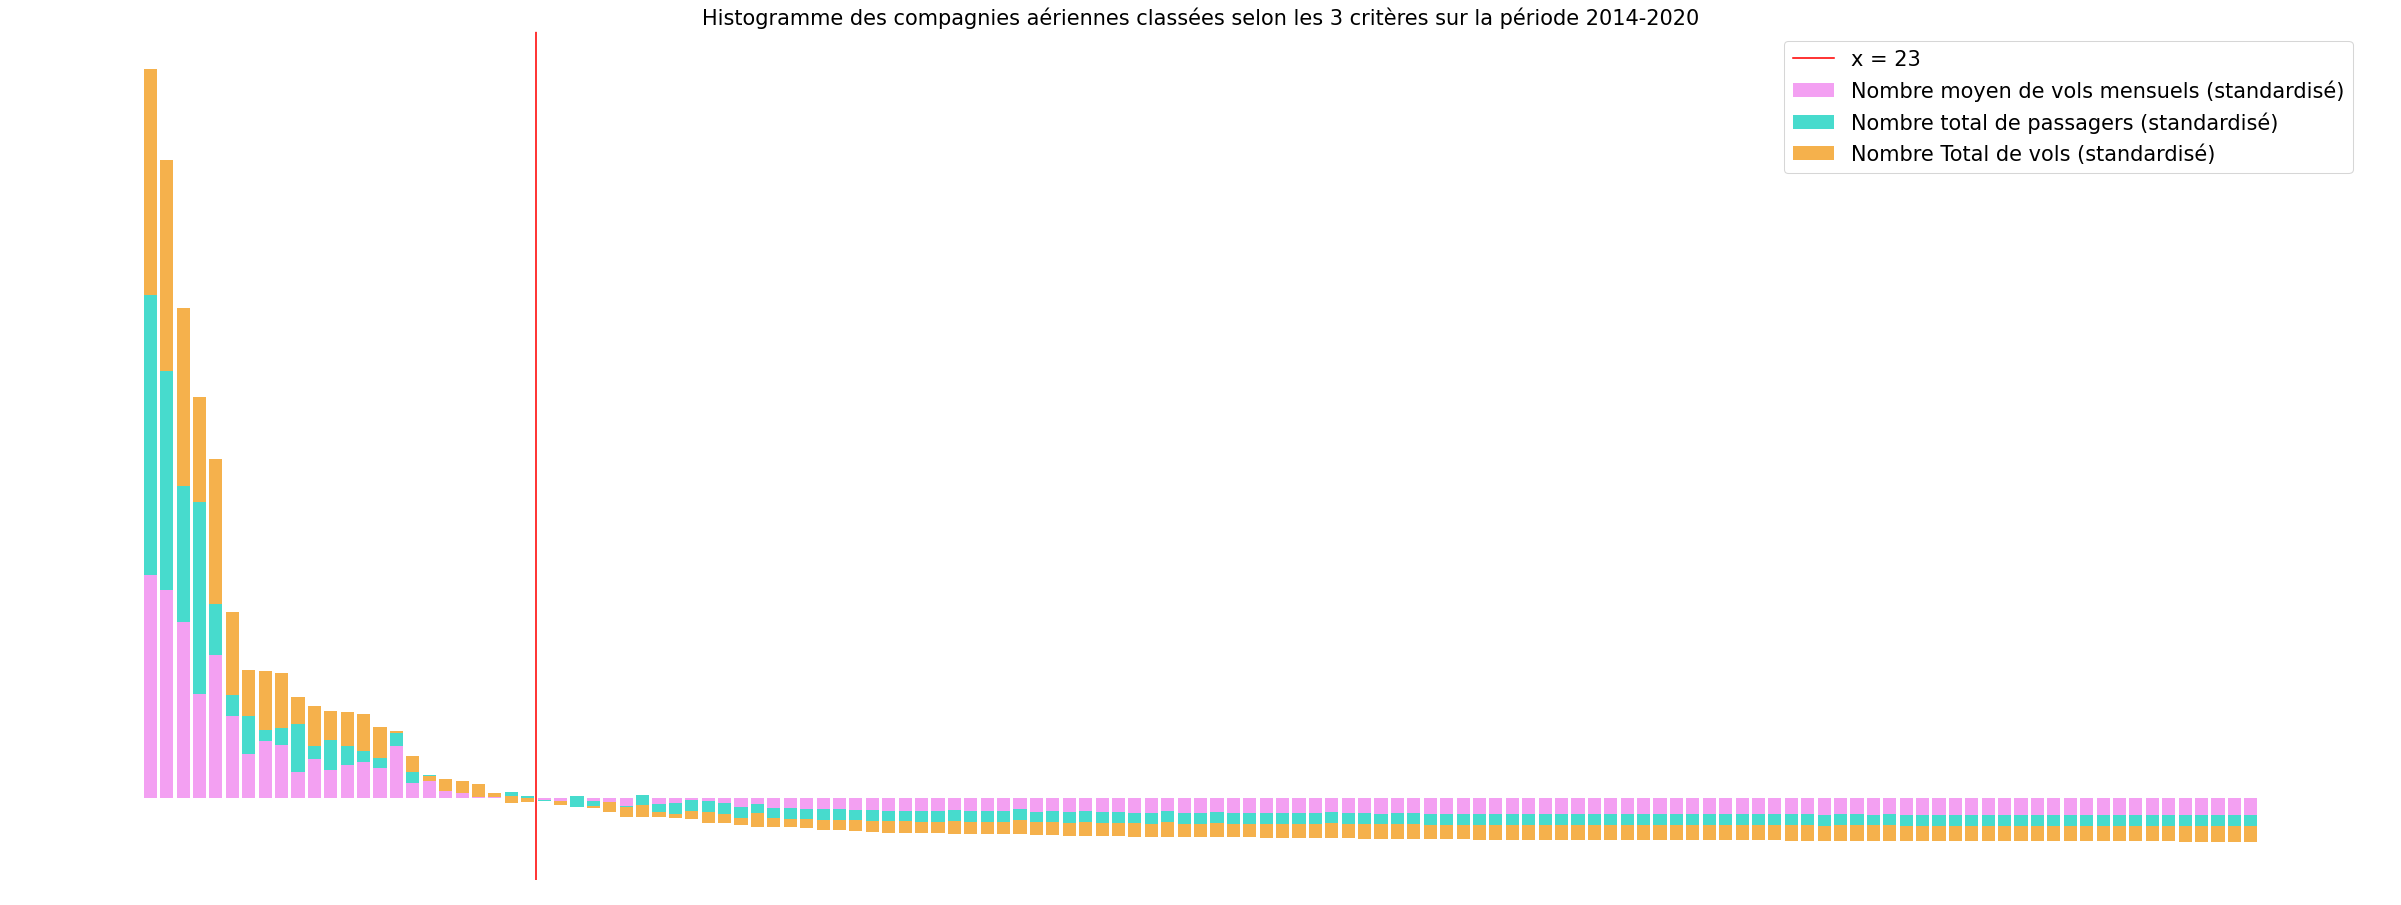

In [12]:
copy.sort_values('TOTAL', inplace=True, ascending = False)
plt.bar(copy['UNIQUE_CARRIER_NAME'], copy['MOY_NB_FLIGHTS'], color = 'C1', label = 'Nombre moyen de vols mensuels (standardisé)')
plt.bar(copy['UNIQUE_CARRIER_NAME'], copy['TOT_PASS_FLIGHTS'], bottom = copy['MOY_NB_FLIGHTS'], color = 'C2', label = 'Nombre total de passagers (standardisé)')
plt.bar(copy['UNIQUE_CARRIER_NAME'], copy['TOT_NB_FLIGHTS'], bottom = copy['MOY_NB_FLIGHTS'] + copy['TOT_PASS_FLIGHTS'], color = 'C3', label = 'Nombre Total de vols (standardisé)')
plt.axvline(x=23.5, color='r', linestyle='-', label = 'x = 23')
plt.legend(prop={'size': 20})
plt.title("Histogramme des compagnies aériennes classées selon les 3 critères sur la période 2014-2020", fontsize = 20)
plt.show()

In [13]:
carriers_f = copy.iloc[:22, :].reset_index(drop=True)['UNIQUE_CARRIER_NAME'].to_numpy().tolist()
print("List of Carriers to use :")
print('------------------------------')
print(*carriers_f,sep='\n')

List of Carriers to use :
------------------------------
Southwest Airlines Co.
Delta Air Lines Inc.
United Air Lines Inc.
American Airlines Inc.
SkyWest Airlines Inc.
ExpressJet Airlines LLC
Alaska Airlines Inc.
Allegiant Air
Republic Airline
JetBlue Airways
Envoy Air
Spirit Air Lines
Frontier Airlines Inc.
Endeavor Air Inc.
PSA Airlines Inc.
US Airways Inc.
Mesa Airlines Inc.
Shuttle America Corp.
GoJet Airlines LLC d/b/a United Express
Sun Country Airlines d/b/a MN Airlines
Grant Aviation
Air Wisconsin Airlines Corp


### Calculate Load Factor

In [14]:
def extract_monthly_load_factor(data):
  tmp = data.groupby(['UNIQUE_CARRIER_NAME', 'DATE'])["RPM"].sum().reset_index(name="RPM_SUM")
  tmp2 = data.groupby(['UNIQUE_CARRIER_NAME', 'DATE'])["ASM"].sum().reset_index(name="ASM_SUM")
  merged = tmp.merge(tmp2, on=['UNIQUE_CARRIER_NAME', 'DATE'])
  merged["LOAD_FACTOR"] = merged["RPM_SUM"]/merged["ASM_SUM"]
  merged.drop(columns=['RPM_SUM', 'ASM_SUM'], inplace=True)
  return merged

In [16]:
load_factor_data = extract_monthly_load_factor(df)
load_factor_data.head()

,UNIQUE_CARRIER_NAME,DATE,LOAD_FACTOR
0,40-Mile Air,2014-01-01,0.200901
1,40-Mile Air,2014-02-01,0.128607
2,40-Mile Air,2014-03-01,0.206155
3,40-Mile Air,2014-04-01,0.272549
4,40-Mile Air,2014-05-01,0.334689


## Add Some General Statistics
---
- Fuel price
- PMI factor
- Unemployment rate

In [20]:
fuel_price_barrel = pd.read_excel(path + "Other/wti.xlsx")
fuel_price_barrel['Date'] = pd.to_datetime(fuel_price_barrel['Date']).apply(lambda x: x.replace(day=1))
fuel_price_barrel.rename(columns={'Close(CLc1)': 'Price', 'Date': 'DATE'}, inplace=True)
fuel_price_barrel.head()

,DATE,Price
0,2020-12-01,48.42
1,2020-11-01,45.06
2,2020-10-01,35.72
3,2020-09-01,39.86
4,2020-08-01,42.82


In [21]:
PMI_data = pd.read_excel(path + 'Other/Economic-Indicator_United-States-ISM-Manufacturing-PMI_2-Jan-2021.xlsx', sheet_name='First Release Data', header = 3)
PMI_data.drop(index=0, inplace=True)
PMI_data['Original Release Date'] = pd.to_datetime(PMI_data['Original Release Date']).apply(lambda x: x.replace(day=1))
PMI_data['Original Release Date'] = [d.date() for d in PMI_data['Original Release Date']]
PMI_data.rename(columns={'Original Release Date' : 'DATE', 'First Release': 'PMI'}, inplace=True)
PMI_data.drop(columns=['Period'], inplace=True)
PMI_data.head()

,DATE,PMI
1,2020-12-01,57.5
2,2020-11-01,59.3
3,2020-10-01,55.4
4,2020-09-01,56.0
5,2020-08-01,54.2


In [22]:
unemployment_data = pd.read_excel(path + 'Other/Economic-Indicator_United-States-Unemployment-Rate__2-Jan-2021.xlsx', sheet_name='First Release Data', header = 3)
unemployment_data.drop(index=0, inplace=True)
unemployment_data['Original Release Date'] = pd.to_datetime(unemployment_data['Original Release Date']).apply(lambda x: x.replace(day=1))
unemployment_data['Original Release Date'] = [d.date() for d in unemployment_data['Original Release Date']]
unemployment_data.drop(columns=['Period'], inplace=True)
unemployment_data.rename(columns={'Original Release Date': 'DATE', 'First Release': 'UNEMPLOYMENT'}, inplace=True)
unemployment_data.head()

,DATE,UNEMPLOYMENT
1,2020-12-01,6.7%
2,2020-11-01,6.9%
3,2020-10-01,7.9%
4,2020-09-01,8.4%
5,2020-08-01,10.2%


## Features Engineering
---
### Features Distance Group

In [23]:
def get_distance_features(data):
  '''EXTRACTS DISTANCE GROUP FREQ FEATURES'''
  # Count the flights by distance group by data by company
  distances = data.groupby(['UNIQUE_CARRIER_NAME', 'DISTANCE_GROUP', 'DATE'])['DISTANCE_GROUP'].count().reset_index(name="count")
  # Get total of all distance groups by date by company
  distances_2 = distances.groupby(['DATE', 'UNIQUE_CARRIER_NAME'])['count'].sum().reset_index(name='TOTAL')
  # Create Frequency column
  distances = distances.merge(distances_2, 'outer', on=['DATE', 'UNIQUE_CARRIER_NAME'])
  distances['FREQ'] = distances['count']/(distances['TOTAL'])
  distances.sort_values(['DISTANCE_GROUP', 'DATE']).reset_index(drop=True)
  # Simplify dataset (to set as comment if you want on final dataset)
  final_dataset = distances.drop(columns=['count', 'TOTAL'])
  # Create the features and populate the final dataframe
  dataframe = pd.DataFrame(columns=['UNIQUE_CARRIER_NAME', 'DATE', 'DG_1', 'DG_2', 'DG_3', 'DG_4', 'DG_5'])
  unique_carriers = np.unique(final_dataset['UNIQUE_CARRIER_NAME'])
  DG = []
  for carrier in tqdm(unique_carriers):
    dates = np.unique(final_dataset[final_dataset['UNIQUE_CARRIER_NAME']== carrier]['DATE'])
    for date in dates:
      for i in range(1, 6):
        tmp = final_dataset[(final_dataset['UNIQUE_CARRIER_NAME']== carrier) & (final_dataset['DATE'] == date) & (final_dataset['DISTANCE_GROUP'] == i)]['FREQ'].values
        if len(tmp) == 0:
          DG.append(0)
        else:
          DG.append(np.round(tmp[0], 3))
      tmp = [carrier, date, DG[0], DG[1], DG[2], DG[3], DG[4]]
      df_length = len(dataframe)
      dataframe.loc[df_length] = tmp
      DG = []
  return dataframe

In [25]:
distance_features = get_distance_features(df)
distance_features.head()

,UNIQUE_CARRIER_NAME,DATE,DG_1,DG_2,DG_3,DG_4,DG_5
0,40-Mile Air,2014-01-01,1.0,0,0,0,0
1,40-Mile Air,2014-02-01,1.0,0,0,0,0
2,40-Mile Air,2014-03-01,1.0,0,0,0,0
3,40-Mile Air,2014-04-01,1.0,0,0,0,0
4,40-Mile Air,2014-05-01,1.0,0,0,0,0


In [26]:
#distance_features.to_csv("distance_features.csv")

### Features Aircraft Type Frequency

In [28]:
aircraft_type_freq = df.groupby(['UNIQUE_CARRIER_NAME', 'DATE', 'AIRCRAFT_TYPE'])['AIRCRAFT_TYPE'].count().reset_index(name='COUNT')
ref = df.groupby(['UNIQUE_CARRIER_NAME', 'DATE'])['AIRCRAFT_TYPE'].count().reset_index(name='TOTAL')
final = aircraft_type_freq.merge(ref, on=['UNIQUE_CARRIER_NAME', 'DATE'])
final['FREQ'] = final['COUNT'] / final['TOTAL']
final.head()

,UNIQUE_CARRIER_NAME,DATE,AIRCRAFT_TYPE,COUNT,TOTAL,FREQ
0,40-Mile Air,2014-01-01,35,8,8,1.000000
1,40-Mile Air,2014-02-01,35,9,9,1.000000
2,40-Mile Air,2014-03-01,35,8,8,1.000000
3,40-Mile Air,2014-04-01,35,11,13,0.846154
4,40-Mile Air,2014-04-01,194,2,13,0.153846


In [29]:
aircraft_types = np.unique(final['AIRCRAFT_TYPE'])
dataframe = pd.DataFrame(columns=aircraft_types)
dataframe['UNIQUE_CARRIER_NAME'] = np.nan
dataframe['DATE'] = np.nan
cols = dataframe.columns.tolist()
cols = cols[-2:] + cols[:-2]
dataframe = dataframe[cols]
unique_carriers = np.unique(final['UNIQUE_CARRIER_NAME'])
AT = []
for carrier in tqdm(unique_carriers):
  dates = np.unique(final[final['UNIQUE_CARRIER_NAME']== carrier]['DATE'])
  for date in dates:
    for aircraft_type in aircraft_types:
      tmp = final[(final['UNIQUE_CARRIER_NAME']== carrier) & (final['DATE'] == date) & (final['AIRCRAFT_TYPE'] == aircraft_type)]['FREQ'].values
      if len(tmp) == 0:
        AT.append(0)
      else:
        AT.append(np.round(tmp[0], 3))
    tmp = np.append([carrier, date], AT)
    df_length = len(dataframe)
    dataframe.loc[df_length] = tmp
    AT = []

In [30]:
dataframe['DATE'] = pd.to_datetime(dataframe['DATE'])
dataframe.head()

,UNIQUE_CARRIER_NAME,DATE,10,26,30,31,33,34,35,36,40,42,79,91,117,121,125,131,194,195,325,339,340,345,355,359,360,362,364,366,368,370,390,393,405,406,409,412,415,416,431,432,441,442,448,449,455,456,458,459,461,469,471,479,482,483,484,485,489,491,495,515,530,575,603,608,609,612,614,616,617,619,620,621,622,623,624,625,626,627,628,629,631,632,634,636,637,638,639,641,642,643,646,647,648,650,651,652,655,656,658,663,667,669,671,673,674,675,676,677,678,682,684,685,686,687,688,694,696,698,699,721,722,723,740,750,770,771,774,775,788,819,822,837,838,839,887,888,889
0,40-Mile Air,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,40-Mile Air,2014-02-01,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,40-Mile Air,2014-03-01,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,40-Mile Air,2014-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,40-Mile Air,2014-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# dataframe.to_csv("aircraft_type_frequency_features.csv")

### Features Geographic Destination

#### TOP 1 Destination per Airline

In [ ]:
def get_top1_dest(data):
  test_geo = pd.DataFrame(data.groupby(['UNIQUE_CARRIER_NAME', 'DATE', 'DEST_CITY_NAME'])['DEST_CITY_NAME'].count().reset_index(name="DEST_COUNT")).reset_index(drop=True).drop_duplicates(['UNIQUE_CARRIER_NAME', 'DATE','DEST_COUNT'])
  test_geo_2 = pd.DataFrame(test_geo.groupby(['UNIQUE_CARRIER_NAME', 'DATE'])['DEST_COUNT'].max()).reset_index(drop=False)
  test_geo_top = test_geo.merge(test_geo_2, 'inner', on=['UNIQUE_CARRIER_NAME', 'DATE', 'DEST_COUNT'])
  test_geo_tot = pd.DataFrame(data.groupby(['UNIQUE_CARRIER_NAME', 'DATE'])['DEST_CITY_NAME'].count().reset_index(name="TOTAL")).reset_index(drop=True)
  test_geo_fq_top = test_geo_top.merge(test_geo_tot, 'inner', on=['UNIQUE_CARRIER_NAME', 'DATE'])
  test_geo_fq_top['FREQ'] = test_geo_fq_top['DEST_COUNT']/test_geo_fq_top['TOTAL']
  test_geo_fq_top = test_geo_fq_top.rename(columns = {'DEST_CITY_NAME' : 'TOP1_DEST', 'FREQ': 'TOP_1_DEST_FQ'}).drop(columns=['DEST_COUNT', 'TOTAL'])
  return test_geo_fq_top

In [ ]:
top1_dest_features = get_top1_dest(df)
top1_dest_features.head()

In [ ]:
# top1_dest_features.to_csv("top1_dest_features.csv")

#### TOP 5 DESTINATIONS 

In [ ]:
def get_top5_dest(data):
  test_geo_top5 = pd.DataFrame(data.groupby(['UNIQUE_CARRIER_NAME', 'DATE', 'DEST_CITY_NAME'])['DEST_CITY_NAME'].count().reset_index(name="DEST_COUNT")).reset_index(drop=True)
  test_geo_top5.sort_values(['UNIQUE_CARRIER_NAME', 'DATE','DEST_COUNT'], inplace=True, ascending=False)
  test_geo_top5 = test_geo_top5.sort_values(['UNIQUE_CARRIER_NAME', 'DATE']).set_index(['UNIQUE_CARRIER_NAME', 'DATE']).reset_index()
  carriers = np.unique(test_geo_top5['UNIQUE_CARRIER_NAME'])

  top5dest_data = pd.DataFrame(columns=['UNIQUE_CARRIER_NAME', 'DATE', 'TOP1_DEST', 'TOP2_DEST', 'TOP3_DEST', 'TOP4_DEST', 'TOP5_DEST'])
  for carrier in tqdm(carriers):
    dates = np.unique(test_geo_top5[test_geo_top5['UNIQUE_CARRIER_NAME']== carrier]['DATE'])
    max_location = []
    max_value = []
    for date in dates:
        max_location = test_geo_top5[(test_geo_top5['UNIQUE_CARRIER_NAME']== carrier) & (test_geo_top5['DATE'] == date)]['DEST_CITY_NAME'].values[0:5]
        max_value = test_geo_top5[(test_geo_top5['UNIQUE_CARRIER_NAME']== carrier) & (test_geo_top5['DATE'] == date)]['DEST_COUNT'].values[0:5]
        while len(max_location) < 5:
          max_location = np.append(max_location, None)
        tmp = [carrier, date, max_location[0],  max_location[1],  max_location[2],  max_location[3],  max_location[4]]
        df_length = len(top5dest_data)
        top5dest_data.loc[df_length] = tmp
  return top5dest_data

In [ ]:
top5_dest_features = get_top5_dest(df)
top5_dest_features.head()

In [ ]:
#top5_dest_features.to_csv("top5_dest_features.csv")

#### TOP 5 DESTINATIONS With Weather features

In [ ]:
#! python weather_data.py ##lunch this commend if needed 

In [ ]:
##create empty columns
top5dest_data_mod = top5_dest_features.copy()
features = ['TAVG', 'TMAX', 'PRCP', 'SNOW', 'WSPD', 'TSUN']
num_top = range(1,6)

num_cols = top5dest_data_mod.shape[1]
for n in num_top:
  for f in features:
    nb_col = num_cols - (5 - n)
    name_col = f"TOP{n}_{f}"
    top5dest_data_mod.insert(nb_col, name_col, pd.Series(dtype=float))

In [ ]:
## fill the column with weather data
unique_destinations = pd.read_csv(path + "weather_dataset.csv", header=0, index_col=0)
unique_destinations["DATE"] = pd.to_datetime(unique_destinations["DATE"])

def fill_weather_statistics(row, n=5, features=features):
    """Finds weather statistics for a dataframe row"""
    date = row["DATE"]
    top_range = range(1, n+1)
    for n in top_range:
        top_features = [f"TOP{n}_{f}" for f in features]
        row[top_features] = unique_destinations[
            (unique_destinations["DATE"].dt.year == date.year) &
            (unique_destinations["DATE"].dt.month == date.month) &
            (row[f"TOP{n}_DEST"] == unique_destinations["DEST_CITY_NAME"])
        ][features].values[0]
    return row

In [ ]:
top5dest_data_mod = top5dest_data_mod.progress_apply(fill_weather_statistics, axis=1)
top5dest_data_mod.head()

In [ ]:
#top5dest_data_mod.to_csv("top5_dest_with_temp.csv")

### Statistical Features

In [ ]:
def get_statistical_features(data):
  # NB Flights / Month : 
  count_flights = pd.DataFrame(data.groupby(['UNIQUE_CARRIER_NAME', 'DATE'])['PASSENGERS'].count().reset_index(name = 'NB_FLIGHTS'))
  updated_df = load_factor_data.merge(count_flights, on=['UNIQUE_CARRIER_NAME', 'DATE'])
  # Average Distance Performed 
  avg_distance = pd.DataFrame(data.groupby(['UNIQUE_CARRIER_NAME', 'DATE'])['DISTANCE'].mean().reset_index(name='AVG_DIST'))
  updated_df = updated_df.merge(avg_distance, on=['UNIQUE_CARRIER_NAME', 'DATE'])
  # Average Freight
  avg_freight = pd.DataFrame(data.groupby(['UNIQUE_CARRIER_NAME', 'DATE'])['FREIGHT'].mean().reset_index(name='AVG_FREIGHT'))
  updated_df = updated_df.merge(avg_freight, on=['UNIQUE_CARRIER_NAME', 'DATE'])
  # Average Mail
  avg_mail = pd.DataFrame(data.groupby(['UNIQUE_CARRIER_NAME', 'DATE'])['MAIL'].mean().reset_index(name='AVG_MAIL'))
  updated_df = updated_df.merge(avg_mail, on=['UNIQUE_CARRIER_NAME', 'DATE'])
  # Average Payload
  avg_payload = pd.DataFrame(data.groupby(['UNIQUE_CARRIER_NAME', 'DATE'])['PAYLOAD'].mean().reset_index(name='AVG_PAYLOAD'))
  updated_df = updated_df.merge(avg_payload, on=['UNIQUE_CARRIER_NAME', 'DATE'])
  return updated_df

In [ ]:
statistical_features = get_statistical_features(df)
statistical_features.head()

In [ ]:
statistical_features.to_csv("statistical_features.csv")

### Feature Lagged Load Factor

In [ ]:
# GET 2013 datas
def read_n_clean2(name):
  df = pd.read_csv(name)
  # Drop Unnamed Columns
  df.drop(df.columns[df.columns.str.contains('unnamed', case=False)], axis = 1, inplace = True)
  df['DATE'] =  pd.to_datetime(df[['YEAR', 'MONTH']].assign(DAY=1))
  # We pick only data from 2014 to 2019
  date_ref1 = datetime.datetime(2013, 1, 1)
  date_ref2 = datetime.datetime(2014, 1, 1)
  df = df[(df['DATE'] >= date_ref1) & (df['DATE'] < date_ref2)]
  # We pick only flights with available seats > 10
  df = df[df["SEATS"] > 10].reset_index(drop=True)  

  # We pick only flights with non-null distance travelled 
  df = df[df["DISTANCE"] > 0].reset_index(drop=True) 

  # We dropped the Hageland Airline data -> the company has shut down since 2008 and has very low amounts of tweets
  df = df[df['UNIQUE_CARRIER'] != "H6"]

  # Load-Factor Creation
  df["RPM"] = df["PASSENGERS"] * df["DISTANCE"]
  df["ASM"] = df["SEATS"] * df["DISTANCE"]

  return df

In [ ]:
data_2013 = read_n_clean2("T_100_Domestic_Segment_All_Years_Extended.csv")
data_2013 = data_2013[data_2013['UNIQUE_CARRIER_NAME'].isin(carriers_f)].sort_values('DISTANCE')
load_factor_data_2013 = extract_monthly_load_factor(data_2013)
load_factor_data_2013.head()

# All Features processed
---

In [ ]:
load_factor_data['DATE'] = pd.to_datetime(load_factor_data['DATE'])

time: 6 ms (started: 2021-01-05 11:00:28 +00:00)


In [ ]:
def get_featured_dataset(load_factor_data):
  #distance_features = pd.read_csv("distance_features.csv")
  #top1_dest_features = pd.read_csv("top1_dest_features.csv")
  #top5_dest_features = pd.read_csv("top5_dest_features.csv")
  #top5_dest_features_temp = pd.read_csv("top5_dest_with_temp.csv")
  #statistical_features = pd.read_csv("statistical_features.csv")
  statistical_features.drop(columns='LOAD_FACTOR', inplace=True)
  #aircraft_type_features = pd.read_csv("aircraft_type_frequency_features.csv")

  featured_dataset = distance_features.merge(top1_dest_features,  on=['UNIQUE_CARRIER_NAME', 'DATE'])
  featured_dataset.drop(featured_dataset.columns[featured_dataset.columns.str.contains('unnamed', case=False)], axis = 1, inplace = True)

  featured_dataset = featured_dataset.merge(statistical_features, on=['UNIQUE_CARRIER_NAME', 'DATE'])
  featured_dataset.drop(featured_dataset.columns[featured_dataset.columns.str.contains('unnamed', case=False)], axis = 1, inplace = True)

  featured_dataset['DATE'] = pd.to_datetime(featured_dataset['DATE'])
  featured_dataset = featured_dataset.merge(load_factor_data, on=['UNIQUE_CARRIER_NAME', 'DATE'])
  featured_dataset.drop(featured_dataset.columns[featured_dataset.columns.str.contains('unnamed', case=False)], axis = 1, inplace = True)
  featured_dataset.drop(columns=['TOP1_DEST'], inplace=True)
  featured_dataset['DATE'] = pd.to_datetime(featured_dataset['DATE'])
  top5_dest_features_temp['DATE'] = pd.to_datetime(top5_dest_features_temp['DATE'])
  featured_dataset = featured_dataset.merge(top5_dest_features_temp, on=['UNIQUE_CARRIER_NAME', 'DATE'])

  PMI_data['DATE'] = pd.to_datetime(PMI_data['DATE'])
  featured_dataset = featured_dataset.merge(PMI_data, on=['DATE'])
  fuel_price_barrel['DATE'] = pd.to_datetime(fuel_price_barrel['DATE'])
  featured_dataset = featured_dataset.merge(fuel_price_barrel, on=['DATE'])
  unemployment_data['DATE'] = pd.to_datetime(unemployment_data['DATE'])
  featured_dataset = featured_dataset.merge(unemployment_data, on=['DATE'])
  aircraft_type_features['DATE'] = pd.to_datetime(aircraft_type_features['DATE'])
  featured_dataset = featured_dataset.merge(aircraft_type_features, on=['UNIQUE_CARRIER_NAME', 'DATE'])
  featured_dataset['DATE'] = pd.to_datetime(featured_dataset['DATE'])
  featured_dataset.drop(featured_dataset.columns[featured_dataset.columns.str.contains('unnamed', case=False)], axis = 1, inplace = True)
  return featured_dataset

time: 28 ms (started: 2021-01-05 11:00:30 +00:00)


In [ ]:
featured_dataset = get_featured_dataset(load_factor_data)
featured_dataset.sort_index(axis = 1, inplace=True)
col1 = featured_dataset['UNIQUE_CARRIER_NAME']
col2 = featured_dataset['DATE']
col3 = featured_dataset['LOAD_FACTOR']
featured_dataset.pop('UNIQUE_CARRIER_NAME')
featured_dataset.pop('DATE')
featured_dataset.pop('LOAD_FACTOR')
featured_dataset.insert(0, 'UNIQUE_CARRIER_NAME', col1)
featured_dataset.insert(1, 'DATE', col2)
featured_dataset.insert(featured_dataset.shape[1],'LOAD_FACTOR', col3)
featured_dataset

,UNIQUE_CARRIER_NAME,DATE,194,26,339,35,359,406,416,461,482,530,608,612,614,616,617,619,622,623,624,625,626,627,629,631,634,637,638,650,655,656,673,674,675,676,677,678,687,694,696,698,699,721,722,723,819,822,837,838,839,887,888,889,AVG_DIST,AVG_FREIGHT,AVG_MAIL,AVG_PAYLOAD,DG_1,DG_2,DG_3,DG_4,DG_5,NB_FLIGHTS,PMI,Price,TOP1_DEST,TOP1_PRCP,TOP1_SNOW,TOP1_TAVG,TOP1_TMAX,TOP1_TSUN,TOP1_WSPD,TOP2_DEST,TOP2_PRCP,TOP2_SNOW,TOP2_TAVG,TOP2_TMAX,TOP2_TSUN,TOP2_WSPD,TOP3_DEST,TOP3_PRCP,TOP3_SNOW,TOP3_TAVG,TOP3_TMAX,TOP3_TSUN,TOP3_WSPD,TOP4_DEST,TOP4_PRCP,TOP4_SNOW,TOP4_TAVG,TOP4_TMAX,TOP4_TSUN,TOP4_WSPD,TOP5_DEST,TOP5_PRCP,TOP5_SNOW,TOP5_TAVG,TOP5_TMAX,TOP5_TSUN,TOP5_WSPD,TOP_1_DEST_FQ,UNEMPLOYMENT,LOAD_FACTOR
0,Air Wisconsin Airlines Corp,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.000,404.053512,354.642140,6.591973,8.582344e+05,0.706,0.288,0.007,0.000,0.000,299,57.0,97.41,"Charlotte, NC",71.8,0.0,25.750000,35.6,0.0,10.556667,"Philadelphia, PA",153.0,1.071429,5.460714,25.0,0.0,14.010714,"Washington, DC",247.2,0.000000,26.774194,36.7,0.0,12.212903,"Boston, MA",44.1,0.000000,12.241935,24.4,0.0,18.564516,"Allentown/Bethlehem/Easton, PA",20.9,0.0,19.483871,32.2,0.0,9.603226,0.163880,6.7%,0.739282
1,Alaska Airlines Inc.,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.152,0.351,0.0,0.295,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.202,0.000,0.000,0.000,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.000,1173.775510,13008.870130,2729.788497,9.040299e+05,0.178,0.395,0.119,0.093,0.108,539,57.0,97.41,"Seattle, WA",34.7,0.0,8.654839,26.1,0.0,13.135484,"Anchorage, AK",20.9,465.483871,-2.345161,5.6,0.0,8.900000,"Portland, OR",24.8,0.000000,19.410000,34.4,0.0,10.113333,"Juneau, AK",76.6,0.000000,5.720000,16.7,0.0,12.940000,"San Diego, CA",69.2,0.0,17.100000,32.8,0.0,7.530000,0.224490,6.7%,0.827900
2,Allegiant Air,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.0,0.058,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.776,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.000,0.100,0.000,0.066,0.000,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.000,966.379371,0.000000,0.000000,3.336490e+05,0.110,0.456,0.362,0.047,0.003,572,57.0,97.41,"Sanford, FL",327.5,0.0,23.612903,32.2,0.0,9.835484,"Las Vegas, NV",57.4,0.000000,20.403333,32.8,0.0,13.340000,"Phoenix, AZ",2.6,0.000000,24.712903,37.8,0.0,12.548387,"St. Petersburg, FL",37.7,0.000000,26.770968,36.7,0.0,14.203226,"Wendover, UT",63.8,0.0,20.963333,34.4,0.0,13.746667,0.120629,6.7%,0.855015
3,American Airlines Inc.,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.368,0.0,0.000,0.0,0.172,0.000,0.000,0.019,0.061,0.025,0.000,0.000,0.000,0.006,0.000,0.000,0.284,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.057,0.009,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.000,1123.165939,26116.628821,1301.879185,2.653638e+06,0.199,0.266,0.293,0.105,0.084,687,57.0,97.41,"Dallas/Fort Worth, TX",88.6,0.0,10.266667,28.3,0.0,16.222581,"Chicago, IL",123.9,13.533333,8.486667,23.3,0.0,18.226667,"Miami, FL",400.0,0.000000,28.648387,35.6,0.0,8.006452,"New York, NY",88.8,0.000000,13.803333,30.6,0.0,16.133333,"Los Angeles, CA",2.8,0.0,16.496667,28.3,0.0,13.076667,0.197962,6.7%,0.807851
4,Delta Air Lines Inc.,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023,0.015,0.130,0.0,0.000,0.0,0.101,0.021,0.006,0.000,0.043,0.003,0.000,0.000,0.000,0.000,0.000,0.026,0.130,0.079,0.00,0.0,0.0,0.0,0.0,0.0,0.006,0.162,0.004,0.220,0.000,0.0,0.000,0.0,0.002,0.0,0.000,0.0,0.0,0.000,0.030,0.000,904.897127,7577.173525,6264.973214,8.985811e+05,0.299,0.352,0.161,0.128,0.052,2576,57.0,97.41,"Atlanta, GA",58.2,0.0,21.664516,32.2,0.0,10.354839,"Minneapolis, MN",198.9,0.000

time: 223 ms (started: 2021-01-05 11:00:35 +00:00)


In [ ]:
test = featured_dataset[['UNIQUE_CARRIER_NAME', 'DATE', 'LOAD_FACTOR']]
test = pd.concat([load_factor_data, load_factor_data_2013])
test

,UNIQUE_CARRIER_NAME,DATE,LOAD_FACTOR
0,Air Wisconsin Airlines Corp,2014-01-01,0.739282
1,Air Wisconsin Airlines Corp,2014-02-01,0.751272
2,Air Wisconsin Airlines Corp,2014-03-01,0.786705
3,Air Wisconsin Airlines Corp,2014-04-01,0.809854
4,Air Wisconsin Airlines Corp,2014-05-01,0.832353
...,...,...,...
259,United Air Lines Inc.,2013-08-01,0.886706
260,United Air Lines Inc.,2013-09-01,0.835169
261,United Air Lines Inc.,2013-10-01,0.843798
262,United Air Lines Inc.,2013-11-01,0.822278


time: 21.9 ms (started: 2021-01-05 11:01:00 +00:00)


In [ ]:
tmp_df = pd.DataFrame(columns = ['UNIQUE_CARRIER_NAME', 'DATE', 'LOAD_FACTOR_SHIFTED'])
load_factors_shifted = []
carriers = np.unique(test['UNIQUE_CARRIER_NAME'])

for carrier in tqdm(carriers):
  dates = np.unique(test[test['UNIQUE_CARRIER_NAME'] == carrier]['DATE'])
  for date in dates:
    date = pd.to_datetime(date)
    if date.year != 2013:
      date = date - relativedelta(years=1)
      load_factor_shifted = test[(test['UNIQUE_CARRIER_NAME'] == carrier) & (test['DATE'] == date)]['LOAD_FACTOR'].values
      date = date + relativedelta(years=1)
      # If no data is actual dataset
      if len(load_factor_shifted) == 0:
        load_factor_shifted = [0]
      # If projected date is in the dataset
      tmp_row = [carrier, date, load_factor_shifted[0]]
      df_length = len(tmp_df)
      tmp_df.loc[df_length] = tmp_row

tmp_df.sort_values('DATE', inplace=True)
tmp_df

100%|██████████| 22/22 [00:06<00:00,  3.36it/s]


,UNIQUE_CARRIER_NAME,DATE,LOAD_FACTOR_SHIFTED
0,Air Wisconsin Airlines Corp,2014-01-01,0.694164
72,Alaska Airlines Inc.,2014-01-01,0.829975
1332,Sun Country Airlines d/b/a MN Airlines,2014-01-01,0.721989
144,Allegiant Air,2014-01-01,0.868898
1260,Spirit Air Lines,2014-01-01,0.841816
...,...,...,...
143,Alaska Airlines Inc.,2019-12-01,0.825926
1331,Spirit Air Lines,2019-12-01,0.855324
71,Air Wisconsin Airlines Corp,2019-12-01,0.793741
863,JetBlue Airways,2019-12-01,0.823506


time: 6.59 s (started: 2021-01-05 11:01:06 +00:00)


In [ ]:
featured_dataset = featured_dataset.merge(tmp_df, on = ['UNIQUE_CARRIER_NAME', 'DATE'])
featured_dataset.head()

,UNIQUE_CARRIER_NAME,DATE,194,26,339,35,359,406,416,461,482,530,608,612,614,616,617,619,622,623,624,625,626,627,629,631,634,637,638,650,655,656,673,674,675,676,677,678,687,694,696,698,699,721,722,723,819,822,837,838,839,887,888,889,AVG_DIST,AVG_FREIGHT,AVG_MAIL,AVG_PAYLOAD,DG_1,DG_2,DG_3,DG_4,DG_5,NB_FLIGHTS,PMI,Price,TOP1_DEST,TOP1_PRCP,TOP1_SNOW,TOP1_TAVG,TOP1_TMAX,TOP1_TSUN,TOP1_WSPD,TOP2_DEST,TOP2_PRCP,TOP2_SNOW,TOP2_TAVG,TOP2_TMAX,TOP2_TSUN,TOP2_WSPD,TOP3_DEST,TOP3_PRCP,TOP3_SNOW,TOP3_TAVG,TOP3_TMAX,TOP3_TSUN,TOP3_WSPD,TOP4_DEST,TOP4_PRCP,TOP4_SNOW,TOP4_TAVG,TOP4_TMAX,TOP4_TSUN,TOP4_WSPD,TOP5_DEST,TOP5_PRCP,TOP5_SNOW,TOP5_TAVG,TOP5_TMAX,TOP5_TSUN,TOP5_WSPD,TOP_1_DEST_FQ,UNEMPLOYMENT,LOAD_FACTOR,LOAD_FACTOR_SHIFTED
0,Air Wisconsin Airlines Corp,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.000,404.053512,354.642140,6.591973,8.582344e+05,0.706,0.288,0.007,0.000,0.000,299,57.0,97.41,"Charlotte, NC",71.8,0.0,25.750000,35.6,0.0,10.556667,"Philadelphia, PA",153.0,1.071429,5.460714,25.0,0.0,14.010714,"Washington, DC",247.2,0.000000,26.774194,36.7,0.0,12.212903,"Boston, MA",44.1,0.000000,12.241935,24.4,0.0,18.564516,"Allentown/Bethlehem/Easton, PA",20.9,0.0,19.483871,32.2,0.0,9.603226,0.163880,6.7%,0.739282,0.694164
1,Alaska Airlines Inc.,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.152,0.351,0.0,0.295,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.202,0.000,0.000,0.000,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.000,1173.775510,13008.870130,2729.788497,9.040299e+05,0.178,0.395,0.119,0.093,0.108,539,57.0,97.41,"Seattle, WA",34.7,0.0,8.654839,26.1,0.0,13.135484,"Anchorage, AK",20.9,465.483871,-2.345161,5.6,0.0,8.900000,"Portland, OR",24.8,0.000000,19.410000,34.4,0.0,10.113333,"Juneau, AK",76.6,0.000000,5.720000,16.7,0.0,12.940000,"San Diego, CA",69.2,0.0,17.100000,32.8,0.0,7.530000,0.224490,6.7%,0.827900,0.829975
2,Allegiant Air,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.0,0.058,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.776,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.000,0.100,0.000,0.066,0.000,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.000,966.379371,0.000000,0.000000,3.336490e+05,0.110,0.456,0.362,0.047,0.003,572,57.0,97.41,"Sanford, FL",327.5,0.0,23.612903,32.2,0.0,9.835484,"Las Vegas, NV",57.4,0.000000,20.403333,32.8,0.0,13.340000,"Phoenix, AZ",2.6,0.000000,24.712903,37.8,0.0,12.548387,"St. Petersburg, FL",37.7,0.000000,26.770968,36.7,0.0,14.203226,"Wendover, UT",63.8,0.0,20.963333,34.4,0.0,13.746667,0.120629,6.7%,0.855015,0.868898
3,American Airlines Inc.,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.368,0.0,0.000,0.0,0.172,0.000,0.000,0.019,0.061,0.025,0.000,0.000,0.000,0.006,0.000,0.000,0.284,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.057,0.009,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.000,1123.165939,26116.628821,1301.879185,2.653638e+06,0.199,0.266,0.293,0.105,0.084,687,57.0,97.41,"Dallas/Fort Worth, TX",88.6,0.0,10.266667,28.3,0.0,16.222581,"Chicago, IL",123.9,13.533333,8.486667,23.3,0.0,18.226667,"Miami, FL",400.0,0.000000,28.648387,35.6,0.0,8.006452,"New York, NY",88.8,0.000000,13.803333,30.6,0.0,16.133333,"Los Angeles, CA",2.8,0.0,16.496667,28.3,0.0,13.076667,0.197962,6.7%,0.807851,0.801683
4,Delta Air Lines Inc.,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023,0.015,0.130,0.0,0.000,0.0,0.101,0.021,0.006,0.000,0.043,0.003,0.000,0.000,0.000,0.000,0.000,0.026,0.130,0.079,0.00,0.0,0.0,0.0,0.0,0.0,0.006,0.162,0.004,0.220,0.000,0.0,0.000,0.0,0.002,0.0,0.000,0.0,0.0,0.000,0.030,0.000,904.897127,7577.173525,6264.973214,8.985811e+05,0.299,0.352,0.161,0.128,0.052,2576,57.0,97.41,"Atlanta, GA",58.2,0.0,21

time: 122 ms (started: 2021-01-05 11:01:24 +00:00)


In [ ]:
showcase_shift = featured_dataset[featured_dataset['UNIQUE_CARRIER_NAME'] == 'SkyWest Airlines Inc.']
showcase_shift = showcase_shift[['UNIQUE_CARRIER_NAME', 'DATE', 'LOAD_FACTOR', 'LOAD_FACTOR_SHIFTED']]
showcase_shift

,UNIQUE_CARRIER_NAME,DATE,LOAD_FACTOR,LOAD_FACTOR_SHIFTED
16,SkyWest Airlines Inc.,2014-01-01,0.789243,0.784116
38,SkyWest Airlines Inc.,2014-02-01,0.819241,0.805831
60,SkyWest Airlines Inc.,2014-03-01,0.843237,0.826178
82,SkyWest Airlines Inc.,2014-04-01,0.839362,0.818458
104,SkyWest Airlines Inc.,2014-05-01,0.848920,0.836107
126,SkyWest Airlines Inc.,2014-06-01,0.854666,0.842278
148,SkyWest Airlines Inc.,2014-07-01,0.847205,0.831441
170,SkyWest Airlines Inc.,2014-08-01,0.848872,0.834108
192,SkyWest Airlines Inc.,2014-09-01,0.825209,0.807345
214,SkyWest Airlines Inc.,2014-10-01,0.836942,0.823484


time: 24.1 ms (started: 2021-01-05 11:01:27 +00:00)


In [ ]:
#featured_dataset.to_csv('featured_dataset_final.csv')

time: 161 ms (started: 2021-01-05 11:02:51 +00:00)


# **Seasonality**
---

In [ ]:
ts_gb = load_factor_data
ts_gb.head()

,UNIQUE_CARRIER_NAME,DATE,LOAD_FACTOR
0,Air Wisconsin Airlines Corp,2014-01-01,0.739282
1,Air Wisconsin Airlines Corp,2014-02-01,0.751272
2,Air Wisconsin Airlines Corp,2014-03-01,0.786705
3,Air Wisconsin Airlines Corp,2014-04-01,0.809854
4,Air Wisconsin Airlines Corp,2014-05-01,0.832353


time: 8 ms (started: 2021-01-05 11:03:29 +00:00)


In [ ]:
len(np.unique(ts_gb['UNIQUE_CARRIER_NAME']))

22

time: 5.01 ms (started: 2021-01-05 11:03:31 +00:00)


In [ ]:
test_seaso = ts_gb[ts_gb['UNIQUE_CARRIER_NAME']=='Frontier Airlines Inc.'].reset_index(drop=True)
test_seaso.head()

,UNIQUE_CARRIER_NAME,DATE,LOAD_FACTOR
0,Frontier Airlines Inc.,2014-01-01,0.827377
1,Frontier Airlines Inc.,2014-02-01,0.892269
2,Frontier Airlines Inc.,2014-03-01,0.922802
3,Frontier Airlines Inc.,2014-04-01,0.894875
4,Frontier Airlines Inc.,2014-05-01,0.920940


time: 14 ms (started: 2021-01-05 11:03:33 +00:00)


In [ ]:
def plot_seaso(date,val,ts,nbr=6,bool_2020=False,quantile=False,retour=False):
  """
  #param
  date = 'date'
  val = 'value'
  ts = time_serie
  nbr = number of years
  bool_2020 = false means no 2020
  """
  #new columns
  ts['Month'] = ts[date].dt.month
  ts['Year'] = ts[date].dt.year
  if bool_2020 == False:
    ts = ts[ts['Year']<2020]
  #pivot table
  pivot_table = pd.pivot_table(ts, values=val, index=['Month'], columns=['Year'], aggfunc=np.sum)
  if quantile == False:
    pivot_table['b_sup'] = pivot_table.iloc[:,-6:-1].max(axis=1)
    pivot_table['b_inf'] = pivot_table.iloc[:,-7:-2].min(axis=1)
  else:
    pivot_table['b_inf'] = pivot_table.iloc[:,-6:-1].quantile(0.25,axis=1)
    pivot_table['b_sup'] = pivot_table.iloc[:,-7:-2].quantile(0.75,axis=1)
  pivot_table['5 Year Avg'] = pivot_table.iloc[:,-8:-3].mean(axis=1)
  #plot
  plot = go.Figure()
  title = "Seso_graph"
  # Set the colors for the lines
  colors = ['#17becf','#e377c2','#ff7f0e','#2ca02c','darkblue','firebrick',
            '#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b',
            '#e377c2','#7f7f7f','#bcbd22','#17becf' ]
  # Create x-axis labels for the months
  months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
  data = pivot_table
  plot.add_trace(go.Scatter(x=months, y=data['b_sup'],
                            fill=None,
                            mode=None,
                            line_color='lightgray',showlegend=False
                            ))
  plot.add_trace(go.Scatter(x=months, y=data['b_inf'],
                            fill='tonexty',
                            mode=None,
                            line_color='lightgray', showlegend=False
                            ))
  plot.add_trace(go.Scatter(x=months, y=data['5 Year Avg'], name='5 Year Avg',
                            line=dict(color='black', width=4, dash='dot')))


  for i in range(nbr):
      index = -4-i
      plot.add_trace(go.Scatter(x=months, y=data.iloc[:,index], name=data.columns[index],
                              line=dict(color=colors[i], width=4)))
  plot.update_layout(title=title,
                    xaxis_title='Month',
                    yaxis_title='Load factor',
                    template='plotly_white')
  plot.show()
  if retour == True:
    return pivot_table.iloc[:,index:]

time: 36 ms (started: 2021-01-05 11:03:36 +00:00)


In [ ]:
def extract_boundaries(ts, bool_ramp=True):
  #new columns
  ts['Month'] = ts['DATE'].dt.month
  ts['Year'] = ts['DATE'].dt.year
  ts = ts[ts['Year']<2020]
  if not bool_ramp:
    ts = ts[ts['Year']<2019]
  #pivot table
  pivot_table = pd.pivot_table(ts, values='LOAD_FACTOR', index=['Month'], columns=['Year'], aggfunc=np.sum)
  print(pivot_table.iloc[:,-6:-1].columns)
  pivot_table['b_inf'] = pivot_table.iloc[:,-6:-1].quantile(0.25,axis=1)
  print(pivot_table.iloc[:,-7:-2].columns)
  pivot_table['b_sup'] = pivot_table.iloc[:,-7:-2].quantile(0.75,axis=1)
  return pd.DataFrame({'inf' : pivot_table['b_inf'], 'sup': pivot_table['b_sup'],'UNIQUE_CARRIER_NAME': ts['UNIQUE_CARRIER_NAME'][1:13]})
extract_boundaries(test_seaso,False)

Int64Index([2014, 2015, 2016, 2017], dtype='int64', name='Year')
Index([2014, 2015, 2016, 2017], dtype='object', name='Year')


,inf,sup,UNIQUE_CARRIER_NAME
1,0.827251,0.842866,Frontier Airlines Inc.
2,0.853996,0.886568,Frontier Airlines Inc.
3,0.903694,0.912685,Frontier Airlines Inc.
4,0.863481,0.878567,Frontier Airlines Inc.
5,0.849808,0.884722,Frontier Airlines Inc.
6,0.899886,0.915213,Frontier Airlines Inc.
7,0.907119,0.918035,Frontier Airlines Inc.
8,0.861994,0.895922,Frontier Airlines Inc.
9,0.842213,0.871398,Frontier Airlines Inc.
10,0.859256,0.881392,Frontier Airlines Inc.


time: 48.4 ms (started: 2021-01-05 15:18:58 +00:00)


In [ ]:
#plot_seaso('DATE','LOAD_FACTOR',test_seaso,6,False,False) #wihtout 2020
table = plot_seaso('DATE', 'LOAD_FACTOR', test_seaso, 6, False, True, True) #without 2020 and q25/q75 range
table.head()

Year,2014,2015,2016,2017,2018,2019,b_inf,b_sup,5 Year Avg
Month,,,,,,,,,
1,0.827377,0.850289,0.840392,0.826874,0.816658,0.847805,0.826874,0.840392,0.832318
2,0.892269,0.810092,0.884667,0.868630,0.849624,0.861183,0.849624,0.884667,0.861057
3,0.922802,0.890797,0.909313,0.907993,0.895256,0.890402,0.895256,0.909313,0.905232
4,0.894875,0.867802,0.850520,0.873131,0.842614,0.867066,0.850520,0.873131,0.865788
5,0.920940,0.806220,0.872650,0.864337,0.862759,0.882700,0.862759,0.872650,0.865381


time: 318 ms (started: 2021-01-05 11:03:38 +00:00)


# **Label Creation**
---

In [ ]:
years = [2014 + i for i in range(6)]
labels = table.copy()
for year in years:
  labels.loc[(labels[year] <= labels['b_sup']) & (labels[year] >= labels['b_inf']), 'label_'+str(year)] = 0
  labels.loc[(labels[year] > labels['b_sup']) , 'label_'+str(year)] = 1
  labels.loc[(labels[year] < labels['b_inf']) , 'label_'+str(year)] = -1
  del labels[year]
labels.head()

Year,b_inf,b_sup,5 Year Avg,label_2014,label_2015,label_2016,label_2017,label_2018,label_2019
Month,,,,,,,,,
1,0.826874,0.840392,0.832318,0.0,1.0,0.0,0.0,-1.0,1.0
2,0.849624,0.884667,0.861057,1.0,-1.0,0.0,0.0,0.0,0.0
3,0.895256,0.909313,0.905232,1.0,-1.0,0.0,0.0,0.0,-1.0
4,0.850520,0.873131,0.865788,1.0,0.0,0.0,0.0,-1.0,0.0
5,0.862759,0.872650,0.865381,1.0,-1.0,0.0,0.0,0.0,1.0


time: 42.7 ms (started: 2021-01-05 11:03:51 +00:00)


# DATA EXPORTATION & SPLIT
---

In [ ]:
y = featured_dataset[['UNIQUE_CARRIER_NAME', 'DATE', 'LOAD_FACTOR']].copy()
X = featured_dataset.drop(columns = ['LOAD_FACTOR']).copy()
date_ref1 = datetime.datetime(2014, 1, 1)
date_ref2 = datetime.datetime(2018, 1, 1)
date_ref3 = datetime.datetime(2019, 1, 1)
date_ref4 = datetime.datetime(2020, 1, 1)
X['DATE'] = pd.to_datetime(X['DATE'])
y['DATE'] = pd.to_datetime(y['DATE'])
X_train_local = X[(X['DATE'] >= date_ref1) & (X['DATE'] < date_ref2)] # 2014 à fin 2017
X_test_local = X[(X['DATE'] >= date_ref2) & (X['DATE'] < date_ref3)] # 2018
X_train_ramp = X[(X['DATE'] >= date_ref1) & (X['DATE'] < date_ref3)] # 2014 à fin 2018
X_test_ramp = X[(X['DATE'] >= date_ref3) & (X['DATE'] < date_ref4)] # 2019
y_train_local = y[(y['DATE'] >= date_ref1) & (y['DATE'] < date_ref2)] # 2014 à fin 2017
y_test_local = y[(y['DATE'] >= date_ref2) & (y['DATE'] < date_ref3)] # 2018
y_train_ramp = y[(y['DATE'] >= date_ref1) & (y['DATE'] < date_ref3)] # 2014 à fin 2018
y_test_ramp = y[(y['DATE'] >= date_ref3) & (y['DATE'] < date_ref4)] # 2019

In [ ]:
X_train_local.to_csv('X_train_local.csv')
X_test_local.to_csv('X_test_local.csv')
X_train_ramp.to_csv('X_train_ramp.csv')
X_test_ramp.to_csv('X_test_ramp.csv')
y_train_local.to_csv('y_train_local.csv')
y_test_local.to_csv('y_test_local.csv')
y_train_ramp.to_csv('y_train_ramp.csv')
y_test_ramp.to_csv('y_test_ramp.csv')